# 🚦 Road Accident Risk — Playground Series S5E10  
### Residual-boosted, calibrated risk scoring pipeline  
LightGBM → XGBoost (prior-corrected residual) → NNLS blend (non-negative)

Goal: produce a stable accident-risk score in [0,1] using a 3-stage pipeline, not just a single model.

**Stage 1 — LightGBM (main learner)**  
Learns the primary risk signal from road geometry, speed limit, lighting, weather, etc.  
Uses seed bagging for smoother OOF predictions.

**Stage 2 — XGBoost (prior-corrected residual learner)**  
We build an interpretable safety prior `risk_prior` ∈ [0,1]  
(sharp curve + high speed + night + bad weather ⇒ higher danger).  
XGBoost only learns what this prior misses:  
`residual = true_risk - risk_prior`, then we add the prior back.

**Stage 3 — NNLS Blend (non-negative convex combiner)**  
Non-negative least squares learns weights for Stage 1 & Stage 2.  
Weights can’t go negative, so each model only adds signal.  
Final predictions are clipped to [0,1].

## Setup & Imports


In [1]:
# --- Core imports & global config
import os, time, warnings, random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from scipy.optimize import nnls
from scipy.stats import pearsonr

from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# XGBoost is optional (not all Kaggle runtimes have it / sometimes no GPU)
try:
    import xgboost as xgb
except Exception:
    xgb = None
    print("XGBoost not available in this environment. Stage 2 will be skipped.")


# Silence minor warnings to keep notebook clean
warnings.filterwarnings("ignore")

# Display / plotting prefs
pd.options.display.max_columns = 200
pd.options.display.width = 180

plt.style.use("default")
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.25

def rmse(a, b) -> float:
    """Root Mean Squared Error (RMSE)."""
    return float(np.sqrt(mean_squared_error(a, b)))

# --- Reproducibility / runtime knobs ---

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

FAST_MODE   = False      # True => faster dev run (fewer trees / fewer seeds)
CV_SPLITS   = 5          # K folds
BINS_FOR_CV = 25         # quantile bins for stratified regression CV
N_JOBS      = os.cpu_count() or -1

ID_COL        = "id"
TARGET        = "accident_risk"
TARGET_BOUNDS = (0.0, 1.0)   # clip final predictions to this range

USE_RESIDUAL_MODEL = True   # Stage 2: XGBoost prior-corrected residual learner
USE_CALIBRATION    = True   # final clipping + OOF sanity checks

if FAST_MODE:
    N_SEEDS_LGB = 2
    LGB_TREES   = 600
    XGB_TREES   = 800
else:
    N_SEEDS_LGB = 2   # you can raise to 4 for extra stability (longer runtime)
    LGB_TREES   = 1100
    XGB_TREES   = 1200

SEED_SCHEDULE = [SEED + 1337 * i for i in range(N_SEEDS_LGB)]

# Decide best XGBoost tree_method depending on runtime (GPU or not)
_GPU_VISIBLE   = os.environ.get("CUDA_VISIBLE_DEVICES")
GPU_AVAILABLE  = (_GPU_VISIBLE not in (None, "", "-1"))
XGB_TREE_METHOD = "gpu_hist" if GPU_AVAILABLE else "hist"

# Working dir (for submission file)
WORK_DIR = Path("/kaggle/working")
WORK_DIR.mkdir(parents=True, exist_ok=True)

print(f"CV={CV_SPLITS} folds | stratified bins={BINS_FOR_CV}")
print(f"LGB_TREES={LGB_TREES} | XGB_TREES={XGB_TREES}")
print(f"Residual stage enabled? {USE_RESIDUAL_MODEL}")
print(f"Blending+clipping enabled? {USE_CALIBRATION}")
print(f"XGBoost tree_method: {XGB_TREE_METHOD} | GPU_AVAILABLE={GPU_AVAILABLE}")


CV=5 folds | stratified bins=25
LGB_TREES=1100 | XGB_TREES=1200
Residual stage enabled? True
Blending+clipping enabled? True
XGBoost tree_method: hist | GPU_AVAILABLE=False


## Load Data


In [2]:

TRAIN_FILE   = "/kaggle/input/playground-series-s5e10/train.csv"
TEST_FILE    = "/kaggle/input/playground-series-s5e10/test.csv"
SAMPLE_FILE  = "/kaggle/input/playground-series-s5e10/sample_submission.csv"

# Load CSVs
train_raw  = pd.read_csv(TRAIN_FILE)
test_raw   = pd.read_csv(TEST_FILE)
sample_sub = pd.read_csv(SAMPLE_FILE)


# Preview basic shapes / sanity check

print(f"Train shape: {train_raw.shape} | Test shape: {test_raw.shape}")
display(train_raw.head())

# --- Integrity checks / no-leakage policy ---------------------------------

# 1. Train must contain all test columns + the target
expected_cols = set(test_raw.columns.tolist() + [TARGET])
missing_cols  = [c for c in expected_cols if c not in train_raw.columns]
assert len(missing_cols) == 0, f"Train is missing expected columns: {missing_cols}"

# 2. Target must only exist in train, never in test
assert TARGET in train_raw.columns, f"Target column '{TARGET}' not found in train."
assert TARGET not in test_raw.columns, "Test should not contain the target."

# 3. ID column must exist in both
assert ID_COL in train_raw.columns, f"ID column '{ID_COL}' not found in train."
assert ID_COL in test_raw.columns,  f"ID column '{ID_COL}' not found in test."

# We'll work on local copies
train = train_raw.copy()
test  = test_raw.copy()

print("Data integrity checks passed.")
print("Using official competition data (train/test from /kaggle/input).")
print("No external data. No test-target leakage.")


Train shape: (517754, 14) | Test shape: (172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


Data integrity checks passed.
Using official competition data (train/test from /kaggle/input).
No external data. No test-target leakage.


## Quick Data Exploration

Before modeling, we inspect the basic structure of the data:

- Target (`accident_risk`): confirm it behaves like a continuous score in [0,1].
- Missing values: check whether we need any cleaning or imputation.
- Feature vs target: see if known risk factors (curvature, speed limit, lighting, weather) relate to higher `accident_risk`.
- Correlations: check if the signal is spread across many features or dominated by a single column.

This gives context for the models that follow.

If you only care about the modeling pipeline, skip ahead to  
**"Modeling — Residual-Boosted Risk Pipeline (Stage 1 → Stage 2 → Stage 3)".**


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes:

,count,mean,std,min,25%,50%,75%,max
id,517754.000000,258876.500000,149462.849974,0.000000,129438.250000,258876.500000,388314.750000,517753.000000
num_lanes,517754.000000,2.491511,1.120434,1.000000,1.000000,2.000000,3.000000,4.000000
curvature,517754.000000,0.488719,0.272563,0.000000,0.260000,0.510000,0.710000,1.000000
speed_limit,517754.000000,46.112575,15.788521,25.000000,35.000000,45.000000,60.000000,70.000000
num_reported_accidents,517754.000000,1.187970,0.895961,0.000000,1.000000,1.000000,2.000000,7.000000
accident_risk,517754.000000,0.352377,0.166417,0.000000,0.230000,0.340000,0.460000,1.000000


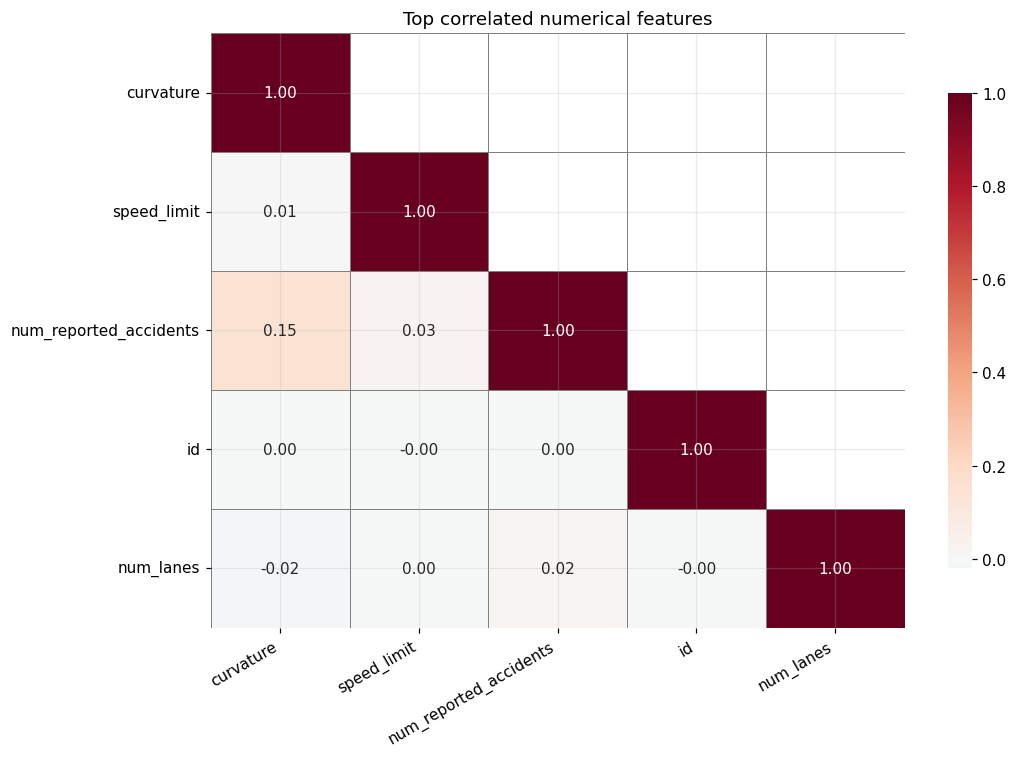

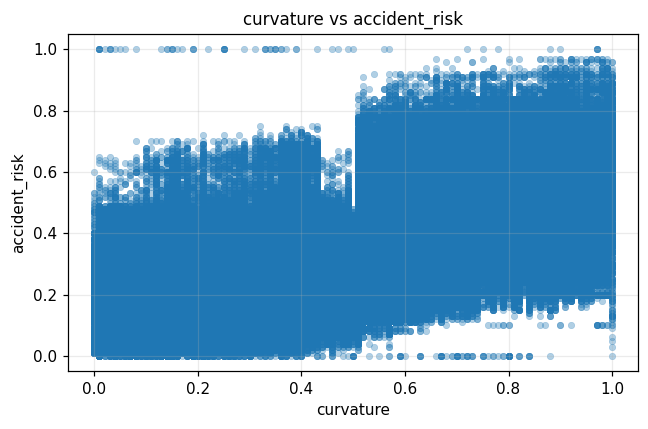

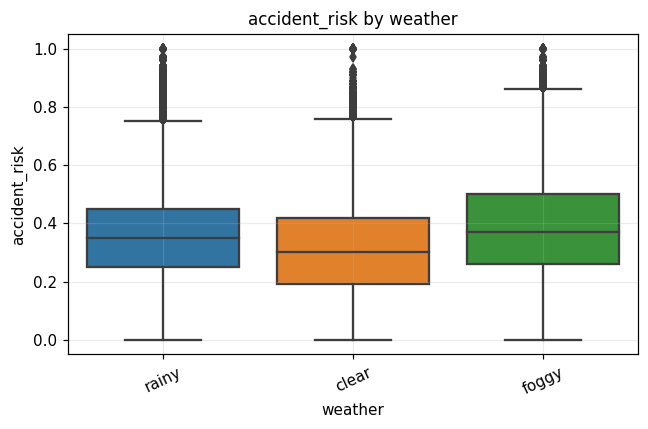

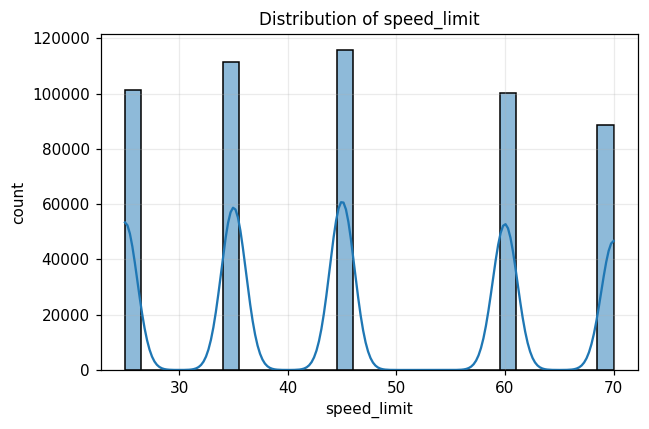

In [3]:
# --- Basic dataset audit ---------------------------------------------------
# - dtypes / structure
# - missingness
# - numeric summary
# - correlations / simple relationships

print("Dataset Overview:")
train.info()

# --- Missing values --------------------------------------------------------
missing = (
    train.isnull()
         .mean()
         .sort_values(ascending=False)
)
missing = missing[missing > 0]

print("\nMissing Values (ratio):")
if len(missing) > 0:
    display(missing.to_frame("missing_ratio"))
else:
    print("No missing values detected.")

# --- Numerical summary -----------------------------------------------------
print("\nNumerical Summary:")
try:
    display(
        train.describe()
             .T
             .style.background_gradient(cmap="Blues")
    )
except Exception:
    # fallback if .style isn't available 
    display(train.describe().T)

# --- Correlation with target ----------------------------------------------
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
corr = train[num_cols].corr()

# Sort features by absolute correlation with the target
target_corr = (
    corr[TARGET]
    .drop(TARGET)
    .sort_values(ascending=False)
)

top_features = target_corr.abs().head(12).index.tolist()

# Heatmap on the most relevant numerical features (for readability)
mask = np.triu(np.ones((len(top_features), len(top_features))), k=1)

plt.figure(figsize=(10,7))
sns.heatmap(
    corr.loc[top_features, top_features],
    cmap="RdBu_r",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.6,
    linecolor="gray",
    mask=mask,
    cbar_kws={"shrink": 0.8},
)
plt.title("Top correlated numerical features", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Example relationship: curvature vs accident_risk ---------------------
if "curvature" in train.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x=train["curvature"],
        y=train[TARGET],
        alpha=0.35,
        edgecolor=None,
        s=18
    )
    plt.title("curvature vs accident_risk", fontsize=11)
    plt.xlabel("curvature")
    plt.ylabel("accident_risk")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# --- Risk by weather category  ------------------------------
if "weather" in train.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(
        x=train["weather"],
        y=train[TARGET]
    )
    plt.title("accident_risk by weather", fontsize=11)
    plt.xlabel("weather")
    plt.ylabel("accident_risk")
    plt.xticks(rotation=25)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# --- Speed limit distribution ------------------------------
if "speed_limit" in train.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(
        train["speed_limit"],
        bins=30,
        kde=True
    )
    plt.title("Distribution of speed_limit", fontsize=11)
    plt.xlabel("speed_limit")
    plt.ylabel("count")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


### EDA Summary

- The target `accident_risk` behaves like a continuous score in [0,1], so we can treat this as a bounded regression problem and later clip predictions to [0,1].
- There is no single dominant driver of risk. The signal is spread across multiple features (curvature, speed_limit, lighting, weather, etc.).
- The relationships look non-linear and depend on interactions (for example: high curvature + high speed + night is worse than any of them alone).

Based on this, the modeling will be done in three stages:
1. Stage 1 — LightGBM (main learner): fit the main accident-risk signal.
2. Stage 2 — XGBoost (prior-corrected residual learner): learn what a simple human safety prior does not explain.
3. Stage 3 — NNLS Blend (non-negative): combine both models with non-negative weights and clip to [0,1].

This staged approach is what we refer to as "residual boosting".


### Feature Engineering & Risk Prior

We add a few simple features:
- `curv_speed` = curvature × speed_limit
- `acc_per_lane` = accidents per lane
- `critical_zone` = 1 if curvature is high and speed_limit is high

We also build a manual `risk_prior` score in [0,1] from curvature, speed, lighting, and weather.

In Stage 2 (XGBoost residual):
- we train on `accident_risk - risk_prior`
- at inference we do `risk_prior + predicted_residual`

So Stage 2 learns what the simple prior did not explain.


## Feature engineering 

Feature engineering applied.
Train shape after FE: (517754, 19) | Test shape after FE: (172585, 18)


,curvature,speed_limit,curv_speed,acc_log,critical_zone
0,0.06,35,2.10,0.693147,0
1,0.99,35,34.65,0.000000,0
2,0.63,70,44.10,1.098612,0
3,0.07,35,2.45,0.693147,0
4,0.58,60,34.80,0.693147,0


risk_prior added.
min     0.071429
max     1.000000
mean    0.499443
Name: risk_prior, dtype: float64


,risk_prior,accident_risk
0,0.318000,0.13
1,0.397000,0.35
2,0.389000,0.30
3,0.321000,0.21
4,0.545429,0.56


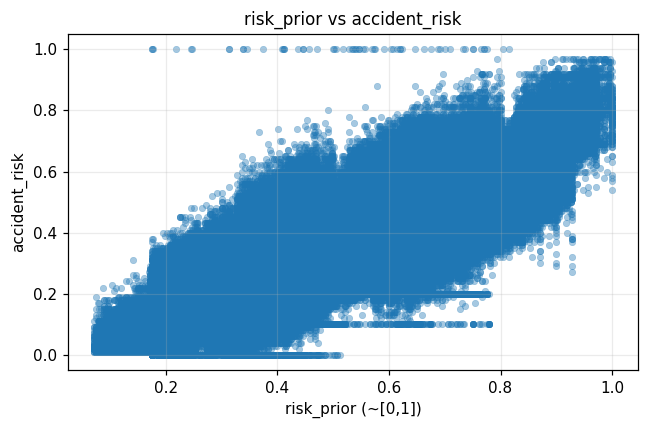

In [4]:


required_cols = ["curvature", "speed_limit", "num_reported_accidents"]
missing_required = [c for c in required_cols if c not in train.columns]
assert len(missing_required) == 0, f"Missing required columns: {missing_required}"

def _col(df, name, dtype=float, fill=0.0):
    """Safe column accessor with fallback default."""
    if name in df.columns:
        return df[name].astype(dtype).values
    return np.full(len(df), fill, dtype=dtype)

def engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # normalize basic categoricals if present
    for c in ("lighting", "weather"):
        if c in df.columns:
            s = df[c].astype(str).str.lower().str.strip()
            df[c] = s.replace({"nan": "unknown"}).fillna("unknown")

    curvature   = _col(df, "curvature", float, 0.0)
    speed_limit = _col(df, "speed_limit", float, 0.0)
    num_acc     = _col(df, "num_reported_accidents", float, 0.0)
    num_lanes   = _col(df, "num_lanes", float, 1.0)

    # interpretable engineered features
    df["curv_speed"]    = curvature * speed_limit
    df["curv_ratio"]    = curvature / np.where(speed_limit == 0, 1.0, speed_limit)
    df["acc_log"]       = np.log1p(np.clip(num_acc, 0, None))
    df["acc_per_lane"]  = num_acc / np.where(num_lanes == 0, 1.0, num_lanes)
    df["critical_zone"] = ((curvature > 0.6) & (speed_limit > 80)).astype(int)

    return df

train = engineer(train)
test  = engineer(test)

print("Feature engineering applied.")
print(f"Train shape after FE: {train.shape} | Test shape after FE: {test.shape}")
display(train[["curvature", "speed_limit", "curv_speed", "acc_log", "critical_zone"]].head())

# --- Interpretable prior ---------------------------------------------------

def risk_prior_fn(df: pd.DataFrame) -> np.ndarray:
    """Hand-designed baseline risk score in [0,1]."""
    n = len(df)

    curvature = _col(df, "curvature", float, 0.0)
    speed_lim = _col(df, "speed_limit", float, 0.0)

    lighting = df.get("lighting", pd.Series(["unknown"] * n)).astype(str).str.lower()
    weather  = df.get("weather",  pd.Series(["clear"]   * n)).astype(str).str.lower()

    night_flag = (lighting == "night").astype(int).values
    badwx_flag = (weather  != "clear").astype(int).values  # anything not "clear" = worse condition

    # normalize curvature/speed to [0,1] scale
    curv_norm  = curvature / (curvature.max() + 1e-9)
    speed_norm = speed_lim / (speed_lim.max() + 1e-9)

    score = (
        0.30 * curv_norm +
        0.20 * speed_norm +
        0.30 * night_flag +
        0.20 * badwx_flag
    )

    return np.clip(score, 0, 1).astype(float)

train["risk_prior"] = risk_prior_fn(train)
test["risk_prior"]  = risk_prior_fn(test)

print("risk_prior added.")
print(train["risk_prior"].describe()[["min", "max", "mean"]])
display(train[["risk_prior", TARGET]].head())

# --- risk_prior vs true target --------------------------------------------

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=train["risk_prior"],
    y=train[TARGET],
    alpha=0.4,
    edgecolor=None,
    s=18
)
plt.title("risk_prior vs accident_risk", fontsize=11)
plt.xlabel("risk_prior (~[0,1])")
plt.ylabel("accident_risk")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


### Feature Documentation

`curv_speed`  
→ curvature × speed_limit. Captures "sharp turn at high speed".

`acc_per_lane`  
→ reported accidents per lane. Normalizes by road capacity.

`critical_zone`  
→ 1 if curvature is high and speed_limit is high (high-curvature / high-speed segment).

`risk_prior`  
→ manual baseline risk score in [0,1] using curvature, speed, lighting (day/night), and weather (clear / not clear). Used later in Stage 2.


## Encoding & Final Feature Matrix

We label-encode string categorical columns (e.g. `lighting`, `weather`) using a shared encoder across train and test.

This is not target leakage:  
- the test data does not include the `accident_risk` target,  
- we do not copy any target info from train into test,  
- we only combine train+test when fitting the label encoders so that unseen categories at inference time are handled.  
This is the usual deployment setup: the model should know all possible categories it may face.

After encoding:
- `X` = feature matrix for training (drops `id`, drops the target)
- `y` = target (`accident_risk`) for training
- `X_test` = test features with the same columns and order as `X`


In [5]:
# --- Categorical encoding --------------------------------------------------

cat_cols = [
    c for c in train.columns
    if train[c].dtype == "object" and c not in [ID_COL, TARGET]
]

encoders = {}

for c in cat_cols:
    le = LabelEncoder()
    both = pd.concat([train[c].astype(str), test[c].astype(str)], axis=0)
    le.fit(both)
    train[c] = le.transform(train[c].astype(str)).astype("int32")
    test[c]  = le.transform(test[c].astype(str)).astype("int32")
    encoders[c] = le

print(f"Categorical columns encoded: {cat_cols}")

# --- Build final feature matrices -----------------------------------------

feat_cols = [c for c in train.columns if c not in [ID_COL, TARGET]]

X      = train[feat_cols].copy()
y      = train[TARGET].astype(float).copy()
X_test = test[feat_cols].copy()

num_cols_model = [c for c in feat_cols if np.issubdtype(X[c].dtype, np.number)]
cat_cols_model = [c for c in cat_cols if c in feat_cols]

assert list(X.columns) == list(X_test.columns), "Feature mismatch between train and test."
assert y.notnull().all(), "Target contains NaNs."

print("Feature matrix ready.")
print(f"Total features: {len(feat_cols)}")
print(f"{len(num_cols_model)} numeric | {len(cat_cols_model)} categorical")
print(f"Target range: {y.min():.4f} → {y.max():.4f} | mean={y.mean():.4f}")


Categorical columns encoded: ['road_type', 'lighting', 'weather', 'time_of_day']
Feature matrix ready.
Total features: 18
14 numeric | 4 categorical
Target range: 0.0000 → 1.0000 | mean=0.3524


## Cross-Validation Strategy

We use stratified K-fold CV to build out-of-fold (OOF) predictions.

To keep each fold balanced between low-risk and high-risk samples, we:
1. bin the continuous target `accident_risk` into `BINS_FOR_CV` quantile buckets,
2. run `CV_SPLITS`-fold `StratifiedKFold` on those bins.

This avoids having one fold that is mostly "safe" segments and another fold that is mostly "dangerous" segments, and it gives OOF predictions that we later use for evaluation and blending.


In [6]:
def make_folds_stratified_reg(y, n_splits=5, seed=42, bins=25):
    """
    Build stratified folds for a continuous target by:
    1. binning y into quantile buckets,
    2. running StratifiedKFold on those bins.

    Returns:
        folds   : list of (train_idx, valid_idx) pairs
        y_bins  : bin index per sample (for diagnostics / debugging)
    """
    assert bins <= len(y), "bins must be <= number of samples"

    y_bins = pd.qcut(y, q=bins, duplicates="drop").cat.codes

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=seed
    )
    fold_pairs = list(skf.split(np.zeros(len(y)), y_bins))

    return fold_pairs, y_bins


folds, y_bins = make_folds_stratified_reg(
    y,
    n_splits=CV_SPLITS,
    seed=SEED,
    bins=BINS_FOR_CV
)

print(
    f"CV folds: {len(folds)} | "
    f"stratified bins: {y_bins.nunique()}"
)


CV folds: 5 | stratified bins: 25


### Modeling — Residual-Boosted Risk Pipeline

**Stage 1 — LightGBM (main learner)**  
Train LightGBM directly on `accident_risk`.  
We also train with multiple random seeds and average the out-of-fold (OOF) predictions to reduce variance.

**Stage 2 — XGBoost (prior-corrected residual learner)**  
We first build a simple manual risk score `risk_prior` in [0,1] using curvature, speed, lighting (day/night), and weather.  
Then we train XGBoost on the residual:
`residual_target = accident_risk - risk_prior`  
At inference:
`predicted_risk = risk_prior + predicted_residual`

So Stage 2 focuses on what the simple prior did not explain.

**Stage 3 — NNLS Blend (non-negative convex combiner)**  
We fit non-negative least squares (NNLS) on the OOF predictions from Stage 1 and Stage 2.  
NNLS gives non-negative weights, so each model only adds signal.  
We clip the final blended predictions to [0,1].

All training and evaluation use official competition data only.  
No external data. No test target leakage. All metrics are OOF.


## Stage 1: LightGBM main learner



[Stage 1 / LightGBM] seed 42 (1/2)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 957
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 17
[LightGBM] [Info] Start training from score 0.352360
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[560]	valid_0's l2: 0.00314458
  Fold 1 RMSE (this seed) = 0.05608 (best_iter=560)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 17
[LightGBM] [Info] Start t

,feature,importance
2,curvature,5698.0
17,risk_prior,5329.0
13,curv_ratio,3508.0
12,curv_speed,2910.0
11,num_reported_accidents,2195.0
15,acc_per_lane,1833.0
5,weather,1569.0
1,num_lanes,1551.0
8,time_of_day,1376.0
3,speed_limit,1351.0


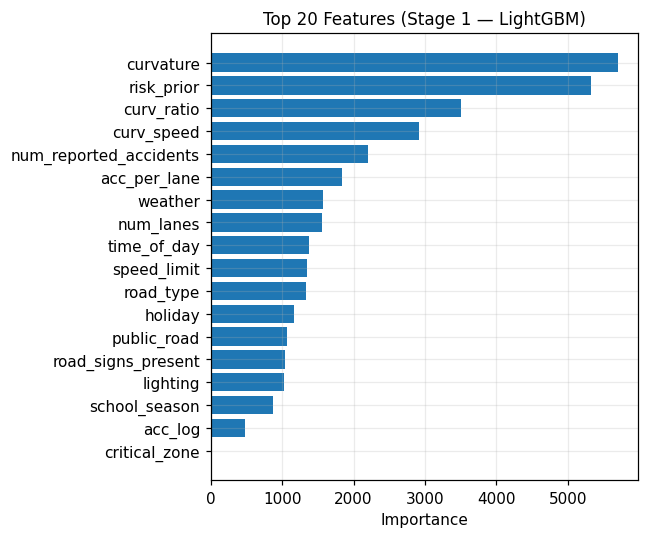

In [7]:
# - Train directly on accident_risk
# - Bag across multiple random seeds 
# - Collect OOF predictions and per-fold RMSE

base_params = dict(
    n_estimators=LGB_TREES,
    learning_rate=0.042 if not FAST_MODE else 0.05,
    num_leaves=55,
    subsample=0.9,
    colsample_bytree=0.82,
    min_child_samples=40,
    reg_lambda=0.05,
    n_jobs=N_JOBS,
)

oof_lgb        = np.zeros(len(X), dtype=float)
pred_lgb       = np.zeros(len(X_test), dtype=float)
fold_rmses_lgb = []
best_iters_lgb = []

t_lgb = time.perf_counter()

for seed_idx, seed in enumerate(SEED_SCHEDULE, start=1):
    params = {**base_params, "random_state": seed}

    oof_tmp  = np.zeros(len(X), dtype=float)
    pred_tmp = np.zeros(len(X_test), dtype=float)

    print(f"\n[Stage 1 / LightGBM] seed {seed} ({seed_idx}/{len(SEED_SCHEDULE)})")

    for f, (tr_idx, va_idx) in enumerate(folds, start=1):
        model_lgb = LGBMRegressor(**params)

        model_lgb.fit(
            X.iloc[tr_idx], y.iloc[tr_idx],
            eval_set=[(X.iloc[va_idx], y.iloc[va_idx])],
            callbacks=[early_stopping(100), log_evaluation(0)],
        )

        best_iters_lgb.append(int(model_lgb.best_iteration_))

        # OOF preds for this fold
        oof_tmp[va_idx] = model_lgb.predict(
            X.iloc[va_idx],
            num_iteration=model_lgb.best_iteration_
        )

        # Test preds (fold-avg within this seed)
        pred_tmp += model_lgb.predict(
            X_test,
            num_iteration=model_lgb.best_iteration_
        ) / len(folds)

        fold_rmse = rmse(y.iloc[va_idx], oof_tmp[va_idx])
        print(f"  Fold {f} RMSE (this seed) = {fold_rmse:.5f} (best_iter={model_lgb.best_iteration_})")


    # Average this seed into global accumulators
    oof_lgb  += oof_tmp  / len(SEED_SCHEDULE)
    pred_lgb += pred_tmp / len(SEED_SCHEDULE)

    seed_rmse = rmse(y, oof_tmp)
    print(f"Seed OOF RMSE = {seed_rmse:.5f}")

# After averaging across seeds, compute per-fold RMSE using final OOF
for _, va_idx in folds:
    fold_rmses_lgb.append(rmse(y.iloc[va_idx], oof_lgb[va_idx]))

elapsed_lgb = time.perf_counter() - t_lgb

rmse_lgb = rmse(y, oof_lgb)

print("\n[Stage 1 — LightGBM summary]")
print(f"OOF RMSE              = {rmse_lgb:.5f}")
print(f"Per-fold RMSE         = {[f'{v:.5f}' for v in fold_rmses_lgb]}")
print(f"Fold RMSE std         = {np.std(fold_rmses_lgb):.5f}")
print(f"Runtime (s)           = {elapsed_lgb:.1f}")
print(f"Mean(best_iteration_) = {np.mean(best_iters_lgb):.1f}")

# Optional diagnostics (can be skipped to keep the notebook lighter)
if False:
    lgb_residual = y.values - oof_lgb

    plt.figure(figsize=(6,4))
    sns.histplot(lgb_residual, bins=40, kde=True)
    plt.title("Residuals After LightGBM (Stage 1)", fontsize=11)
    plt.xlabel("true - lgb_pred")
    plt.ylabel("count")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.scatter(
        oof_lgb,
        lgb_residual,
        s=10,
        alpha=0.4
    )
    plt.axhline(0, color="#555555", linestyle="--", linewidth=1)
    plt.title("Residuals vs LightGBM OOF Prediction", fontsize=11)
    plt.xlabel("LightGBM OOF prediction")
    plt.ylabel("true - pred")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Feature importance from the last fitted model
try:
    importances = pd.DataFrame({
        "feature": X.columns,
        "importance": model_lgb.feature_importances_.astype(float),
    }).sort_values("importance", ascending=False)

    top_imp = importances.head(20)

    print("\nTop LightGBM features:")
    display(top_imp)

    plt.figure(figsize=(6,5))
    plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
    plt.title("Top 20 Features (Stage 1 — LightGBM)", fontsize=11)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Feature importance skipped:", e)


## Stage 2 — XGBoost (prior-corrected residual learner)

In [8]:
# Train on (accident_risk - risk_prior), then add risk_prior back at inference.

if (xgb is None) or (not USE_RESIDUAL_MODEL):
    print("Stage 2 skipped (XGBoost not available or residual stage disabled).")
    oof_xgb        = np.zeros(len(X), dtype=float)
    pred_xgb       = np.zeros(len(X_test), dtype=float)
    fold_rmses_xgb = []
    best_iters_xgb = []
    rmse_xgb       = rmse(y, oof_xgb)

else:
    # residual target: what the simple prior did not explain
    xgb_target = (y.values - train["risk_prior"].values).astype(float)

    oof_xgb        = np.zeros(len(X), dtype=float)
    pred_xgb       = np.zeros(len(X_test), dtype=float)
    fold_rmses_xgb = []
    best_iters_xgb = []

    t_xgb = time.perf_counter()

    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.035 if not FAST_MODE else 0.05,
        "max_depth": 6,
        "subsample": 0.92,
        "colsample_bytree": 0.86,
        "lambda": 1.0,
        "alpha": 0.6,
        "tree_method": XGB_TREE_METHOD, 
        "seed": SEED,
        "nthread": -1,
    }

    print(f"[Stage 2 / XGBoost] tree_method = {XGB_TREE_METHOD}")

    for f, (tr_idx, va_idx) in enumerate(folds, start=1):
        dtrain = xgb.DMatrix(X.iloc[tr_idx],  label=xgb_target[tr_idx])
        dvalid = xgb.DMatrix(X.iloc[va_idx],  label=xgb_target[va_idx])
        dtest  = xgb.DMatrix(X_test)

        booster = xgb.train(
            params=xgb_params,
            dtrain=dtrain,
            num_boost_round=XGB_TREES,
            evals=[(dvalid, "valid")],
            early_stopping_rounds=100,
            verbose_eval=False,
        )

        best_iter        = getattr(booster, "best_iteration", None)
        best_ntree_limit = getattr(booster, "best_ntree_limit", None)
        best_iters_xgb.append(int(best_iter) if best_iter is not None else None)

        # predict residuals on valid and test
        if best_ntree_limit is not None:
            valid_residual_pred = booster.predict(dvalid, ntree_limit=int(best_ntree_limit))
            test_residual_pred  = booster.predict(dtest,  ntree_limit=int(best_ntree_limit))
        elif best_iter is not None:
            valid_residual_pred = booster.predict(dvalid, iteration_range=(0, int(best_iter)+1))
            test_residual_pred  = booster.predict(dtest,  iteration_range=(0, int(best_iter)+1))
            best_ntree_limit = int(best_iter) + 1
        else:
            valid_residual_pred = booster.predict(dvalid)
            test_residual_pred  = booster.predict(dtest)

        # map residuals back to full accident_risk space
        oof_xgb[va_idx] = valid_residual_pred + train["risk_prior"].values[va_idx]
        pred_xgb       += (test_residual_pred + test["risk_prior"].values) / len(folds)

        fold_rmse = rmse(y.iloc[va_idx], oof_xgb[va_idx])
        fold_rmses_xgb.append(fold_rmse)
        print(f"  Fold {f} RMSE = {fold_rmse:.5f} | best_iter={best_iter} | best_ntree_limit={best_ntree_limit}")

    elapsed_xgb = time.perf_counter() - t_xgb
    rmse_xgb    = rmse(y, oof_xgb)

    print("\n[Stage 2 — XGBoost summary]")
    print(f"OOF RMSE                      = {rmse_xgb:.5f}")
    print(f"Per-fold RMSE                 = {[f'{v:.5f}' for v in fold_rmses_xgb]}")
    print(f"Fold RMSE std                 = {np.std(fold_rmses_xgb):.5f}")
    print(f"Runtime (s)                   = {elapsed_xgb:.1f}")
    print(f"Best iterations (first folds) = {best_iters_xgb[:5]}")


[Stage 2 / XGBoost] tree_method = hist
  Fold 1 RMSE = 0.05605 | best_iter=1084 | best_ntree_limit=1085
  Fold 2 RMSE = 0.05583 | best_iter=963 | best_ntree_limit=964
  Fold 3 RMSE = 0.05617 | best_iter=1082 | best_ntree_limit=1083
  Fold 4 RMSE = 0.05607 | best_iter=1147 | best_ntree_limit=1148
  Fold 5 RMSE = 0.05605 | best_iter=1075 | best_ntree_limit=1076

[Stage 2 — XGBoost summary]
OOF RMSE                      = 0.05604
Per-fold RMSE                 = ['0.05605', '0.05583', '0.05617', '0.05607', '0.05605']
Fold RMSE std                 = 0.00011
Runtime (s)                   = 133.2
Best iterations (first folds) = [1084, 963, 1082, 1147, 1075]


## Stage Comparison (Stage 1 vs Stage 2)

In [9]:
# Stage-wise OOF RMSE comparison (Stage 1 vs Stage 2)

rmse_lgb = rmse(y, oof_lgb)
rmse_xgb = rmse(y, oof_xgb)

comp_df = pd.DataFrame({
    "Stage": [
        "Stage 1 — LightGBM (main learner)",
        "Stage 2 — XGBoost (prior-corrected residual learner)",
    ],
    "OOF_RMSE": [
        rmse_lgb,
        rmse_xgb,
    ],
    "Δ vs Stage 1": [
        0.0,
        rmse_lgb - rmse_xgb,
    ],
    "Notes": [
        "Fits accident_risk directly",
        "Trains on (accident_risk - risk_prior), then adds risk_prior back",
    ],
})

print("Stage RMSE comparison:")
try:
    display(
        comp_df.style.format({
            "OOF_RMSE": "{:.5f}",
            "Δ vs Stage 1": "{:+.5f}",
        }).background_gradient(
            cmap="Blues",
            subset=["OOF_RMSE", "Δ vs Stage 1"]
        )
    )
except Exception:
    print(comp_df.to_string(index=False))


Stage RMSE comparison:


,Stage,OOF_RMSE,Δ vs Stage 1,Notes
0,Stage 1 — LightGBM (main learner),0.05606,+0.00000,Fits accident_risk directly
1,Stage 2 — XGBoost (prior-corrected residual learner),0.05604,+0.00002,"Trains on (accident_risk - risk_prior), then adds risk_prior back"


<!-- ### Stage Comparison (LightGBM vs XGBoost)

We now compare the out-of-fold RMSE for:
- Stage 1 (LightGBM trained directly on the true `accident_risk`)
- Stage 2 (XGBoost trained on the prior-corrected target, i.e. `true_risk - risk_prior`, then mapped back to full risk space)

If Stage 2 achieves a lower OOF RMSE than Stage 1, that means the prior-corrected learner is capturing extra structure that the direct LightGBM model did not fully explain.  
In other words, the second model is adding real signal — not just noise. -->


## Stage 3 — NNLS Blend (non-negative convex combiner)


[Stage 3 / NNLS Blend] Weights:
  Stage 1 — LightGBM (main learner)                        : 0.3735
  Stage 2 — XGBoost (prior-corrected residual learner)     : 0.6265

[Stage 3 — NNLS Blend summary]
OOF RMSE (Stage 1 — LightGBM)                              = 0.05606
OOF RMSE (Stage 2 — XGBoost, prior-corrected residual)     = 0.05604
OOF RMSE (Stage 3 — NNLS Blend, non-negative convex mix)   = 0.05602
Δ vs Stage 1                                               = +0.00004
Δ vs Stage 2                                               = +0.00001


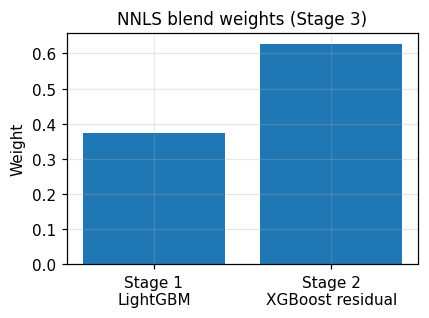


Stage 1 / Stage 2 / Stage 3 comparison:


,Stage,OOF_RMSE,Δ vs Stage 1,Notes
0,Stage 1 — LightGBM (main learner),0.05606,+0.00000,Fits accident_risk directly
1,Stage 2 — XGBoost (prior-corrected residual learner),0.05604,+0.00002,"Learns (accident_risk - risk_prior), then adds risk_prior back"
2,Stage 3 — NNLS Blend (non-negative convex combiner),0.05602,+0.00004,Non-negative convex mix of Stage 1 and Stage 2


In [10]:
# Combine Stage 1 (LightGBM) and Stage 2 (XGBoost residual) using non-negative least squares.
# NNLS enforces weights >= 0, then we normalize so they sum to 1.

oof_stack  = np.vstack([oof_lgb,  oof_xgb]).T   # [n_train, 2]
test_stack = np.vstack([pred_lgb, pred_xgb]).T  # [n_test, 2]

w_raw, _ = nnls(oof_stack, y.values.astype(float))
w = w_raw / (w_raw.sum() + 1e-12)

print("\n[Stage 3 / NNLS Blend] Weights:")
print(f"  Stage 1 — LightGBM (main learner)                        : {w[0]:.4f}")
print(f"  Stage 2 — XGBoost (prior-corrected residual learner)     : {w[1]:.4f}")

blend_oof  = oof_stack  @ w
blend_test = test_stack @ w

rmse_blend = rmse(y, blend_oof)

print("\n[Stage 3 — NNLS Blend summary]")
print(f"OOF RMSE (Stage 1 — LightGBM)                              = {rmse_lgb:.5f}")
print(f"OOF RMSE (Stage 2 — XGBoost, prior-corrected residual)     = {rmse_xgb:.5f}")
print(f"OOF RMSE (Stage 3 — NNLS Blend, non-negative convex mix)   = {rmse_blend:.5f}")
print(f"Δ vs Stage 1                                               = {rmse_lgb - rmse_blend:+.5f}")
print(f"Δ vs Stage 2                                               = {rmse_xgb - rmse_blend:+.5f}")

# visualize the learned NNLS weights
plt.figure(figsize=(4,3))
plt.bar(
    ["Stage 1\nLightGBM", "Stage 2\nXGBoost residual"],
    w
)
plt.title("NNLS blend weights (Stage 3)", fontsize=11)
plt.ylabel("Weight")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Build final comparison table including Stage 3
blend_comp_df = pd.DataFrame({
    "Stage": [
        "Stage 1 — LightGBM (main learner)",
        "Stage 2 — XGBoost (prior-corrected residual learner)",
        "Stage 3 — NNLS Blend (non-negative convex combiner)",
    ],
    "OOF_RMSE": [
        rmse_lgb,
        rmse_xgb,
        rmse_blend,
    ],
    "Δ vs Stage 1": [
        0.0,
        rmse_lgb - rmse_xgb,
        rmse_lgb - rmse_blend,
    ],
    "Notes": [
        "Fits accident_risk directly",
        "Learns (accident_risk - risk_prior), then adds risk_prior back",
        "Non-negative convex mix of Stage 1 and Stage 2",
    ],
})

print("\nStage 1 / Stage 2 / Stage 3 comparison:")
try:
    display(
        blend_comp_df.style.format({
            "OOF_RMSE": "{:.5f}",
            "Δ vs Stage 1": "{:+.5f}",
        }).background_gradient(
            cmap="Blues",
            subset=["OOF_RMSE", "Δ vs Stage 1"]
        )
    )
except Exception:
    print(blend_comp_df.to_string(index=False))


## Final calibration

[Final blended model diagnostics]
OOF RMSE (clipped to [0.0,1.0])     = 0.05602
Pearson r (OOF)                       = 0.9416
Prediction range (OOF)                = 0.0252 → 0.8776
Prediction range (TEST)               = 0.0282 → 0.8729


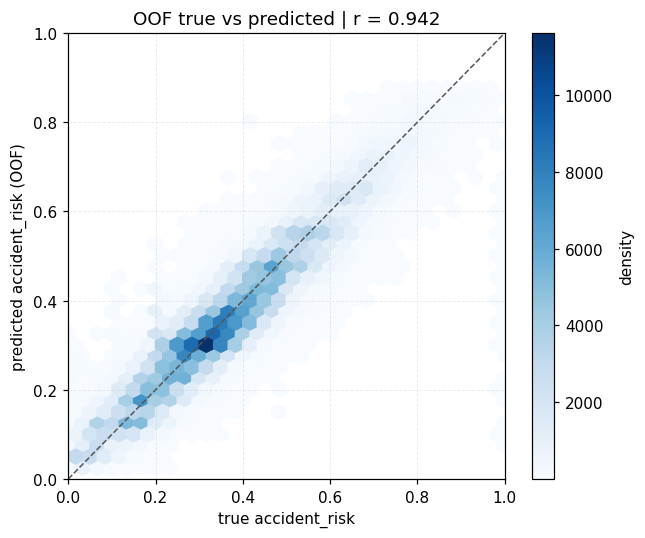

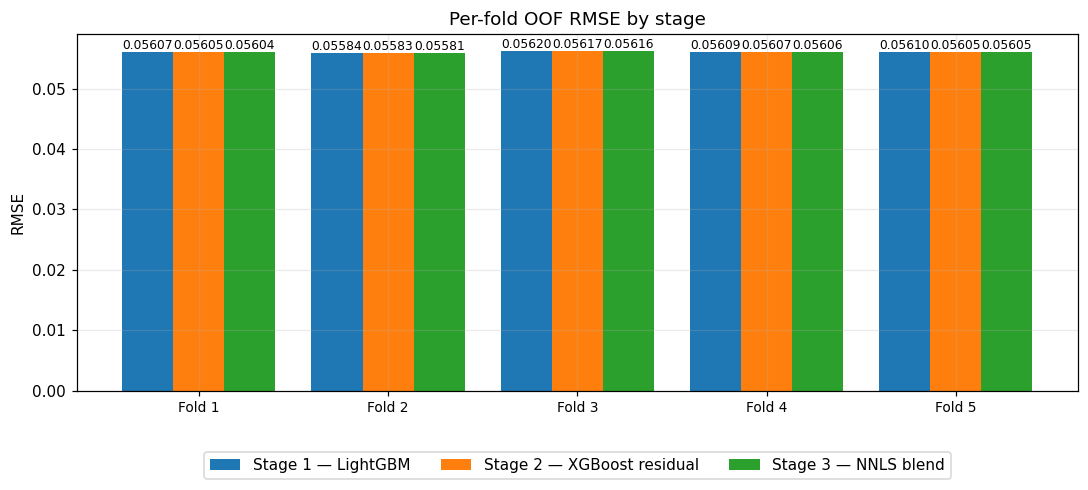

[NNLS weight stability]
Stage 1 — LightGBM weight:     mean=0.3895  std=0.0360
Stage 2 — XGBoost weight:      mean=0.6105  std=0.0360


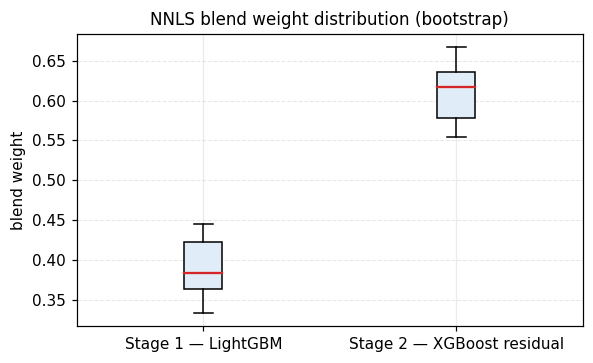

In [11]:
# Final calibration / clipping to [0,1]
lo, hi = TARGET_BOUNDS
final_oof  = np.clip(blend_oof,  lo, hi)
final_test = np.clip(blend_test, lo, hi)

final_rmse = rmse(y, final_oof)
final_r    = pearsonr(y, final_oof)[0]

print("[Final blended model diagnostics]")
print(f"OOF RMSE (clipped to [{lo},{hi}])     = {final_rmse:.5f}")
print(f"Pearson r (OOF)                       = {final_r:.4f}")
print(f"Prediction range (OOF)                = {final_oof.min():.4f} → {final_oof.max():.4f}")
print(f"Prediction range (TEST)               = {final_test.min():.4f} → {final_test.max():.4f}")

# True vs predicted: calibration / monotonicity check
plt.figure(figsize=(6,5))
hb = plt.hexbin(
    y,
    final_oof,
    gridsize=30,
    cmap="Blues",
    mincnt=1,
)
plt.plot([lo, hi], [lo, hi], "--", color="#555555", linewidth=1)
plt.colorbar(hb, label="density")
plt.title(f"OOF true vs predicted | r = {final_r:.3f}", fontsize=12)
plt.xlabel("true accident_risk")
plt.ylabel("predicted accident_risk (OOF)")
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.grid(alpha=0.25, linestyle="--", linewidth=0.6)
plt.tight_layout()
plt.show()

# Per-fold RMSE comparison for all stages
fold_rmses_blend = [rmse(y.iloc[va], blend_oof[va]) for _, va in folds]

idx   = np.arange(1, len(folds) + 1)
width = 0.27

plt.figure(figsize=(10,4.6))

bars_lgb   = plt.bar(idx - width, fold_rmses_lgb,   width, label="Stage 1 — LightGBM")
bars_xgb   = plt.bar(idx,         fold_rmses_xgb,   width, label="Stage 2 — XGBoost residual")
bars_blend = plt.bar(idx + width, fold_rmses_blend, width, label="Stage 3 — NNLS blend")

for rects in [bars_lgb, bars_xgb, bars_blend]:
    for bar in rects:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h,
            f"{h:.5f}",
            ha='center',
            va='bottom',
            fontsize=8,
        )

plt.xticks(idx, [f"Fold {i}" for i in idx], fontsize=9)
plt.ylabel("RMSE", fontsize=10)
plt.title("Per-fold OOF RMSE by stage", fontsize=12)
plt.grid(alpha=0.25, axis='y')
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=True
)
plt.tight_layout()
plt.show()

# Blend weight stability via bootstrap
def nnls_bootstrap(oof_preds, y_true, iters=20, seed=SEED):
    rng = np.random.default_rng(seed)
    weights = []
    n = len(y_true)

    for _ in range(iters):
        idx_bs = rng.integers(0, n, n)
        w_bs, _ = nnls(oof_preds[idx_bs], y_true[idx_bs].astype(float))
        w_bs = w_bs / (w_bs.sum() + 1e-12)
        weights.append(w_bs)

    return np.vstack(weights)

W = nnls_bootstrap(oof_stack, y.values, iters=20, seed=SEED)
mean_lgb, std_lgb = W[:, 0].mean(), W[:, 0].std()
mean_xgb, std_xgb = W[:, 1].mean(), W[:, 1].std()

print("[NNLS weight stability]")
print(f"Stage 1 — LightGBM weight:     mean={mean_lgb:.4f}  std={std_lgb:.4f}")
print(f"Stage 2 — XGBoost weight:      mean={mean_xgb:.4f}  std={std_xgb:.4f}")

plt.figure(figsize=(5.5,3.4))
plt.boxplot(
    W,
    labels=["Stage 1 — LightGBM", "Stage 2 — XGBoost residual"],
    patch_artist=True,
    boxprops=dict(facecolor="#e0ecf8"),
    medianprops=dict(color="#d62728", linewidth=1.5),
)
plt.title("NNLS blend weight distribution (bootstrap)", fontsize=11)
plt.ylabel("blend weight")
plt.grid(axis="y", alpha=0.3, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


## Submission

In [12]:
# Build submission dataframe
submission = pd.DataFrame({
    ID_COL: test[ID_COL].values,
    TARGET: final_test,
})

submit_path = WORK_DIR / "submission.csv"
submission.to_csv(submit_path, index=False)

print("[Submission file]")
print(f"path        : {submit_path}")
print(f"rows        : {submission.shape[0]}")
print(f"columns     : {list(submission.columns)}")
print(f"prediction range (test) : {final_test.min():.4f} → {final_test.max():.4f}")
print(f"prediction mean (test)  : {final_test.mean():.4f}")

display(submission.head())


[Submission file]
path        : /kaggle/working/submission.csv
rows        : 172585
columns     : ['id', 'accident_risk']
prediction range (test) : 0.0282 → 0.8729
prediction mean (test)  : 0.3517


,id,accident_risk
0,517754,0.296907
1,517755,0.120350
2,517756,0.179587
3,517757,0.304998
4,517758,0.400696


## Summary

This notebook trains a 3-stage residual-boosted risk model for `accident_risk`:

**Stage 1 — LightGBM (main learner)**  
Fit `accident_risk` directly from the engineered features.

**Stage 2 — XGBoost (prior-corrected residual learner)**  
Define a simple manual risk score `risk_prior` (curvature, speed, lighting, weather).  
Train XGBoost on the residual `accident_risk - risk_prior`, then add `risk_prior` back at inference.

**Stage 3 — NNLS Blend (non-negative convex combiner)**  
Combine Stage 1 and Stage 2 using non-negative least squares (NNLS).  
Weights are constrained to be ≥ 0, and final predictions are clipped to [0,1].

What we get:  
- Lower OOF RMSE  
- More stable performance across folds  
- Outputs in a valid [0,1] range  
- No external data and no test-target leakage

This setup can be reapplied to other regression problems where part of the signal can be approximated with a simple prior and the remaining structure can be learned as a residual.


## Model Card

**Objective**  
Predict `accident_risk` for each road segment using geometry, speed limit, lighting, weather, and similar contextual features.  
The output is a continuous risk score in `[0, 1]`.

---

**Architecture (3-stage residual boosting)**  
1. **Stage 1 — LightGBM (main learner)**  
   Trained directly on `accident_risk`. Learns the main signal.

2. **Stage 2 — XGBoost (prior-corrected residual learner)**  
   We define a manual `risk_prior` (curvature × speed, night lighting, non-clear weather).  
   XGBoost is trained on the residual `accident_risk - risk_prior`, then we add `risk_prior` back at inference.  
   This focuses the model on what the simple prior did not explain.

3. **Stage 3 — NNLS Blend (non-negative convex combiner)**  
   Stage 1 and Stage 2 predictions are combined using non-negative least squares (NNLS).  
   We constrain weights to be ≥ 0 and normalize them to sum to 1.  
   Final predictions are clipped to `[0, 1]`.

---

**Data & Training**  
- Only the official competition data is used.  
- No external data, and the test set target is never accessed.  
- Cross-validation uses stratified K-fold on quantile bins of the target to balance low-risk and high-risk samples per fold.  
- Blending and clipping are based on out-of-fold (OOF) predictions.

---

**Evaluation**  
- Main metric: RMSE (root mean squared error) on OOF predictions. Lower RMSE = better fit.  
- We also report Pearson correlation between true risk and predicted risk to confirm ranking (higher-risk segments should be scored higher).  
- We monitor per-fold RMSE and the stability of the NNLS blend weights (via bootstrap) to check that performance is not coming from one lucky split.

---

**Intended Use**  
- Produces a relative road safety score per segment.  
- Can be used to sort / rank segments by estimated accident risk.  
- The same pattern can be reused for other regression problems where:
  (a) part of the target can be approximated by a simple prior,  
  (b) the remaining structure can be learned as a residual.

---

**Calibration & Constraints**  
- Predictions are clipped to `[0, 1]`, matching the target range.  
- The NNLS blend is non-negative, so neither model "cancels out" the other with a negative weight.  
- Pearson correlation on OOF predictions is monitored to confirm that higher predicted risk corresponds to higher observed risk.

---

**Limitations**  
- The `risk_prior` is intentionally simple: it does not include traffic volume, driver behavior, or detailed weather severity.  
- Hyperparameters are chosen for stability and reproducibility, not heavy hyper-tuning.  
- Assumes inference data is similar in distribution. Applying to a different region / network would require retraining and validation.

---

**Possible Extensions**  
- Add a third base learner (e.g. CatBoost) and include it in the NNLS blend.  
- Replace NNLS with a regularized linear meta-learner (e.g. Ridge / ElasticNet) while keeping non-negative constraints if needed.  
- Enrich the prior with time-of-day, weekday/weekend, traffic density, or road class.  
- Export the whole pipeline (feature engineering → Stage 1 / Stage 2 → Stage 3 blend) as an inference function or a lightweight API.
